In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import generator
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
M = 10000
(x_train, _), (x_test, _) = mnist('./data')
x_train_generator = generator(x_train, M)

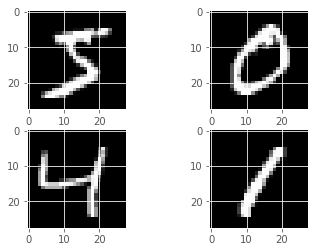

In [3]:
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(x_train[i,:].reshape(28,28),cmap = 'gray')
plt.show()

In [4]:
sess = tf.InteractiveSession()
def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.matmul(h,W_decode) + b_decode
    return h

In [5]:
W_encode = Normal(loc = tf.zeros([28*28, 256]), scale = tf.ones([28*28, 256]))
W_decode = Normal(loc = tf.zeros([256, 28*28]), scale = tf.ones([256,28*28]))
b_encode = Normal(loc = tf.zeros(256), scale = tf.ones(256))
b_decode = Normal(loc = tf.zeros(28*28), scale = tf.ones(28*28))

x = tf.placeholder(tf.float32, [None, 28 * 28])

x_reconstruct = Normal(loc=auto_encoder(x, W_encode, W_decode, b_encode, b_decode),
                      scale = 0.1 *tf.ones([28*28]))


In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([28*28,256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28,256]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([256,28*28])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256,28*28]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([28*28])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28]))))


In [7]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_train})


(4, 60000, 784)


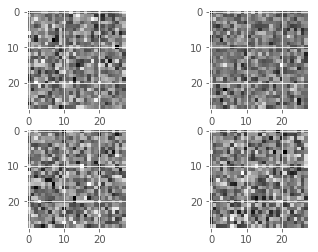

In [8]:
print(out.shape)
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()


In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode}, data = {x: x_train, x_reconstruct: x_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 200
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
6/6 [100%] ██████████████████████████████ Elapsed: 70s
-log p(x) <= 130679491152943.516
Epoch: 2
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 62876450623.761
Epoch: 3
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 3622610682.948
Epoch: 4
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 1892046200.286
Epoch: 5
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 1806753927.441
Epoch: 6
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1769017389.875
Epoch: 7
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1756627206.144
Epoch: 8
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= 1735798624.529
Epoch: 9
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= 1778316773.513
Epoch: 10
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= 1914143803.529
Epoch: 11
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x

6/6 [100%] ██████████████████████████████ Elapsed: 61s
-log p(x) <= 1675346592.836
Epoch: 90
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1675687135.369
Epoch: 91
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= 1699066954.820
Epoch: 92
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1670717636.608
Epoch: 93
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1674144819.883
Epoch: 94
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1672448625.869
Epoch: 95
6/6 [100%] ██████████████████████████████ Elapsed: 61s
-log p(x) <= 1668465679.838
Epoch: 96
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1670992905.284
Epoch: 97
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1696276973.705
Epoch: 98
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1669928355.977
Epoch: 99
6/6 [100%] ██████████████████████████████ Elapsed: 60s
-log p(x) <= 16

6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 1612264732.535
Epoch: 177
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1630738090.121
Epoch: 178
6/6 [100%] ██████████████████████████████ Elapsed: 63s
-log p(x) <= 1618681091.413
Epoch: 179
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1620470765.978
Epoch: 180
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1642599983.787
Epoch: 181
6/6 [100%] ██████████████████████████████ Elapsed: 62s
-log p(x) <= 1620707831.535
Epoch: 182
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1607218635.298
Epoch: 183
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= 1617738194.398
Epoch: 184
6/6 [100%] ██████████████████████████████ Elapsed: 60s
-log p(x) <= 1619720072.943
Epoch: 185
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= 1608545957.751
Epoch: 186
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log 

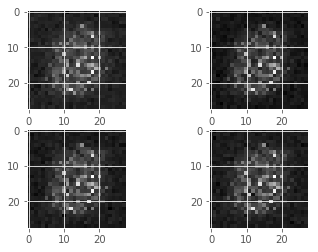

In [14]:
out = sess.run(reconstruct, feed_dict={x: x_train})
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
